# Setting up a classifier with under-sampling and CV
Machine Learning with Imbalanced Data - Course

When we train a classifier, we want it to predict an outcome in a real life dataset. The real datasets, most likely, also have a class imbalance. Thus, it is important to evaluate the performance of the classifier, on a data set with the same distribution of classes, as the one we expect in real life.

This means, that the under-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, the performance of the model should be determined on a portion of the data, that was not re-sampled.

In this notebook, we will use the imbalanced-learn pipeline, to set up various under-sampling solutions, in a way that we train the model on re-sampled data, but we evaluate performance on non resampled data.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

# to correctly setup the cross validation
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import(
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold,
)

In [2]:
undersampler_dict = {
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False,
    ),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1,
    ),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=-1,
    ),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1,
    ),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
    ),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
        max_iter=100,
    ),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
    ),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
        threshold_cleaning=0.5,
    ),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=-1,
    ),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=-1
    ),

    # here I set up a Logistic regression but remember
    # that the authors of this technique concluded that it is best
    # to use the same classifier that will be used to train the final
    # model, so in our case, we should have used a Random Forest
    'iht': InstanceHardnessThreshold(
        estimator=RandomForestClassifier(
            n_estimators=100, random_state=39, max_depth=3, n_jobs=-1),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3),
}

In [3]:
dataset_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level',
]

In [4]:
# print class imbalance for each dataset
# this is to get a tiny bit familiar with the datasets
for dataset in dataset_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance
# with cross-validation
def run_model(X_train, y_train, undersampler=None):
    # set up the classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=39,
        max_depth=3,
        n_jobs=-1,
    )

    # set up a scaler
    scaler = MinMaxScaler()

    # without undersampling
    if not undersampler:
        model = rf
    # set up a pipeline with undersampling
    else:
        # important to scale before the under-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            scaler,
            undersampler,
            rf,
        )
    
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data

    cv_results = cross_validate(
        model, # the random forest or the pipeline
        X_train, # the data that will be used in the cross-validation
        y_train, # the target
        scoring="average_precision", # the metric that we want to evaluate
        cv=3, # the cross-validation fold
    )

    print(
        'Random Forests average precision: {0} +/- {1}'.format(
        cv_results['test_score'].mean(), cv_results['test_score'].std()
        )
    )

    return cv_results['test_score'].mean(), cv_results['test_score'].std()

In [6]:
# now we train several models, with the different under-samplers and
# with cross-validation for each dataset

# to save the results
pr_mean_dict = {}
pr_std_dict = {}

for dataset in dataset_ls:
    
    # initiate a dictionary per dataset
    pr_mean_dict[dataset] = {}
    pr_std_dict[dataset] = {}
    
    print(dataset)
    
    # load dataset
    data = fetch_datasets()[dataset]
    
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,  
        data.target, 
        test_size=0.3,
        random_state=0,
    )
   
    
    # train model on data without re-sampling
    # with cross-validation
    aps_mean, aps_std = run_model(X_train, y_train)
    
    # store results
    pr_mean_dict[dataset]['full_data'] = aps_mean
    pr_std_dict[dataset]['full_data'] = aps_std
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
               
        # resample, train and evaluate performance
        # with cross-validation
        aps_mean, aps_std = run_model(X_train, y_train, undersampler_dict[undersampler])
        
        #store results
        pr_mean_dict[dataset][undersampler] = aps_mean
        pr_std_dict[dataset][undersampler] = aps_std
        print()
        
    print()

car_eval_34
Random Forests average precision: 0.7481090731569603 +/- 0.0640047618385711

random
Random Forests average precision: 0.8181570671248642 +/- 0.04562258395724317

cnn
Random Forests average precision: 0.8078707158816102 +/- 0.04426286224783994

tomek
Random Forests average precision: 0.7474709114272299 +/- 0.07121499807721254

oss
Random Forests average precision: 0.7445064431693446 +/- 0.06825836143641655

enn
Random Forests average precision: 0.7445405722953402 +/- 0.05983859002946621

renn
Random Forests average precision: 0.7317723770289556 +/- 0.07202797152997925

allknn
Random Forests average precision: 0.7402603598630982 +/- 0.04955198309775651

ncr


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Random Forests average precision: 0.7513142576288189 +/- 0.0419320517332791

nm1
Random Forests average precision: 0.8594537556071412 +/- 0.05593173404762631

nm2
Random Forests average precision: 0.47673587861066596 +/- 0.07088082666054629

iht
Random Forests average precision: 0.596924943997066 +/- 0.0025166368588067194


ecoli
Random Forests average precision: 0.6687434616841758 +/- 0.11512585309131046

random
Random Forests average precision: 0.5711727323779753 +/- 0.1528528537899079

cnn
Random Forests average precision: 0.6040406290181617 +/- 0.0828411520329121

tomek
Random Forests average precision: 0.6821649569283789 +/- 0.11787291595381086

oss
Random Forests average precision: 0.652626285579626 +/- 0.14193232688808755

enn
Random Forests average precision: 0.652980365827588 +/- 0.11667023465138066

renn
Random Forests average precision: 0.6814855236180429 +/- 0.07839239625372121

allknn
Random Forests average precision: 0.680188098938099 +/- 0.08845062108441386

ncr


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Random Forests average precision: 0.6499383532450469 +/- 0.0996446410507599

nm1
Random Forests average precision: 0.19122197732743496 +/- 0.07356960377814778

nm2
Random Forests average precision: 0.2599523037280133 +/- 0.04975560410255809

iht
Random Forests average precision: 0.31268594796171895 +/- 0.11983675083583868


thyroid_sick
Random Forests average precision: 0.7322649404994692 +/- 0.03975702483248149

random
Random Forests average precision: 0.746534356826588 +/- 0.04172388457737669

cnn
Random Forests average precision: 0.7937964324657566 +/- 0.0437026169028861

tomek
Random Forests average precision: 0.7593222779660317 +/- 0.05620829078316773

oss
Random Forests average precision: 0.750259089140589 +/- 0.05875266536003168

enn
Random Forests average precision: 0.7136312258985579 +/- 0.0343756133235285

renn
Random Forests average precision: 0.7182000199710555 +/- 0.06061325012287931

allknn
Random Forests average precision: 0.7284694836602091 +/- 0.030213540518168873

ncr

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Random Forests average precision: 0.7532918569817765 +/- 0.05988997835987446

nm1
Random Forests average precision: 0.24529404406508595 +/- 0.035869545843848334

nm2
Random Forests average precision: 0.23274285003601977 +/- 0.1308120202891738

iht
Random Forests average precision: 0.833547949406548 +/- 0.0017174683502416024


arrhythmia
Random Forests average precision: 0.3320173328945259 +/- 0.10781020512179744

random
Random Forests average precision: 0.24046325586656914 +/- 0.12494979519207311

cnn
Random Forests average precision: 0.3685214352343665 +/- 0.09587226829747657

tomek
Random Forests average precision: 0.33416938992032863 +/- 0.1333023409758579

oss
Random Forests average precision: 0.3631330833768914 +/- 0.05830522989632441

enn
Random Forests average precision: 0.3001481114556562 +/- 0.08170216415376094

renn
Random Forests average precision: 0.31198951194049235 +/- 0.062197538141752086

allknn
Random Forests average precision: 0.2809845356168886 +/- 0.0330249670656819

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Random Forests average precision: 0.3231875842124289 +/- 0.08145656768366316

nm1
Random Forests average precision: 0.09788334160786494 +/- 0.03884402809027888

nm2
Random Forests average precision: 0.17033593056966687 +/- 0.08303634829394622

iht
Random Forests average precision: 0.19317612383429084 +/- 0.06900866054157953


ozone_level
Random Forests average precision: 0.29837510195324496 +/- 0.07219095034389267

random
Random Forests average precision: 0.3081627616069132 +/- 0.06493603512675088

cnn
Random Forests average precision: 0.27659236060410247 +/- 0.04482413341386358

tomek
Random Forests average precision: 0.2902272912889723 +/- 0.07831378173485835

oss
Random Forests average precision: 0.2689625947556818 +/- 0.048460167404431265

enn
Random Forests average precision: 0.29103489191490156 +/- 0.06168277038924584

renn
Random Forests average precision: 0.30324282576478007 +/- 0.04381290680069347

allknn
Random Forests average precision: 0.2945568501827357 +/- 0.0302763010096

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Random Forests average precision: 0.32405420526602363 +/- 0.08326164642063212

nm1
Random Forests average precision: 0.05072996878128407 +/- 0.029956040411790858

nm2
Random Forests average precision: 0.2560660990173164 +/- 0.0885058818669043

iht
Random Forests average precision: 0.038665804015220386 +/- 0.016154012286234854




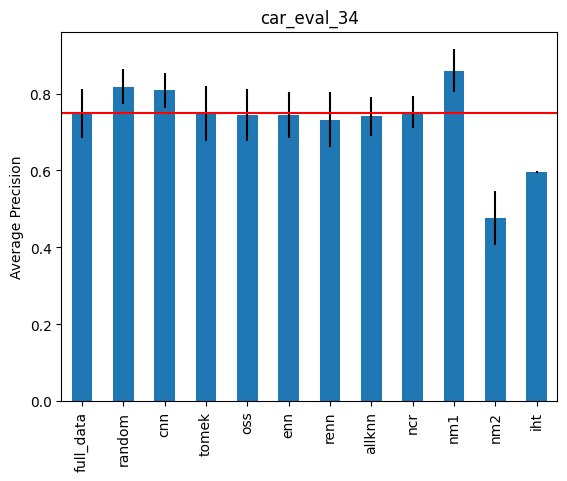

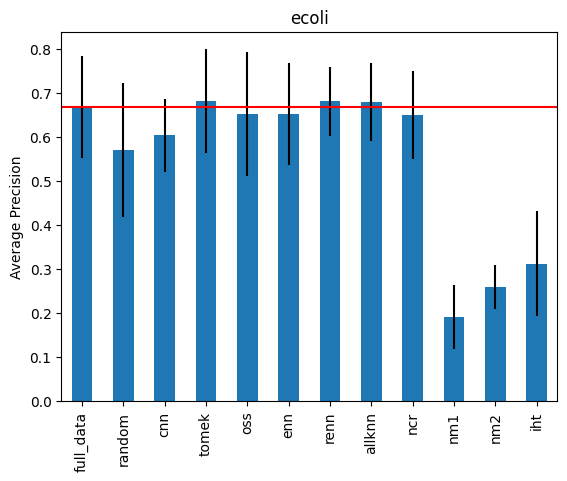

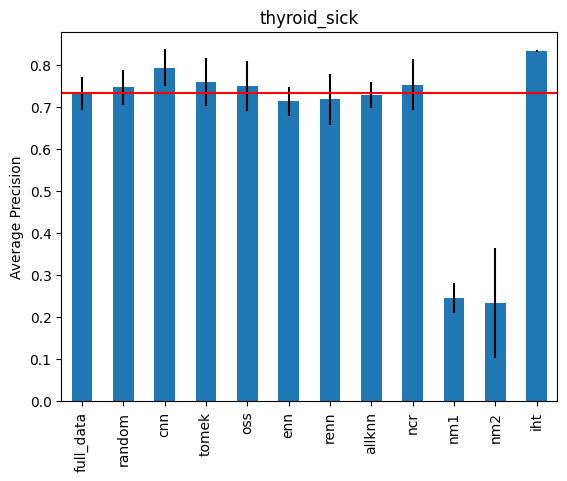

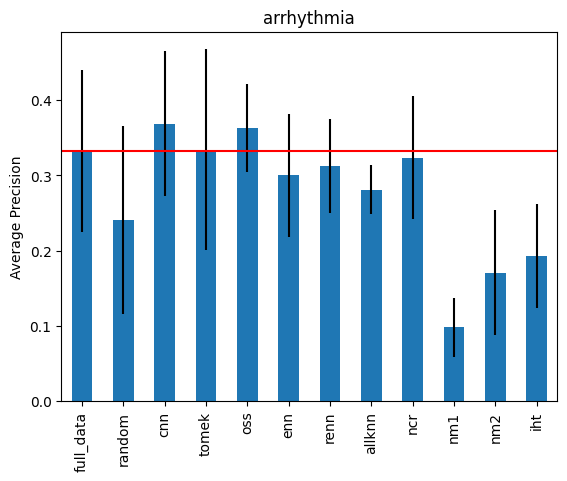

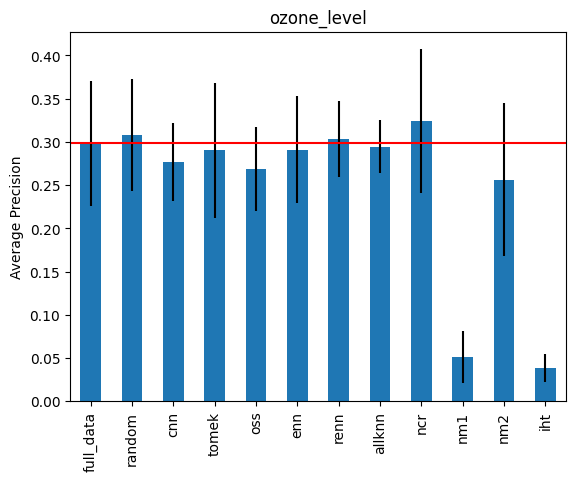

In [8]:
# Now we plot the performance of the model in the 
# left out fold, that was not resampled, from the X_train

for dataset in dataset_ls:
    
    pr_mean_s = pd.Series(pr_mean_dict[dataset])
    pr_std_s = pd.Series(pr_std_dict[dataset])
    
    pr_mean_s.plot.bar(yerr=[pr_std_s, pr_std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average Precision')
    plt.axhline(pr_mean_dict[dataset]['full_data'], color='r')
    plt.show()

* Different under-sampling techniques work best for different datasets.
* ENN, RENN and AllKNN tend to produce similar results, so we may as well just choose one of the 3